In [8]:
import numpy as np
from hsa_hopper.kinematics import KinematicParameters, forward_kinematics
import hsa_hopper.dynamics
from scipy.optimize import root_scalar

# coming up with a y coordinate mapping to test this strategy
L1 = .07
L2 = .15
kin_params = KinematicParameters(L1,L2,.3,0.)
dynamics_params = hsa_hopper.dynamics.DynamicsParameters(1.2,1e-2,.2,1.,1,-35*np.pi/180,kin_params)
tf = .125

# solve for equilibrium angle
theta1 = root_scalar(
    lambda theta: hsa_hopper.dynamics.evaluate(theta,0,0,dynamics_params),
    bracket=(10*np.pi/180,-10*np.pi/180)
    ).root

# theta1 = theta_td = -15*np.pi/180    # starting angle
thetaN = -35*np.pi/180

# now for some boundary conditions
y = lambda x: forward_kinematics(kin_params,x)[0]
dy = lambda x: forward_kinematics(kin_params,x,jacobian=True)[1][0]
d2y = lambda x: forward_kinematics(kin_params,x,jacian=True,hessian=True)[2][0]

y1 = y(theta1)
yN = y(thetaN)
print(y1)
print(yN)
ydot1 = 0
ydotN = .7

thetadot1 = root_scalar(lambda thetadot: dy(theta1)*thetadot-ydot1, bracket=(-20,20)).root
thetadotN = root_scalar(lambda thetadot: dy(thetaN)*thetadot-ydotN, bracket=(-20,20)).root
print(theta1,thetadot1)
print(thetaN,thetadotN)

0.12303833734459657
0.17875789236265796
0.14339454020934317 0.0
-0.6108652381980153 -9.465795474860716


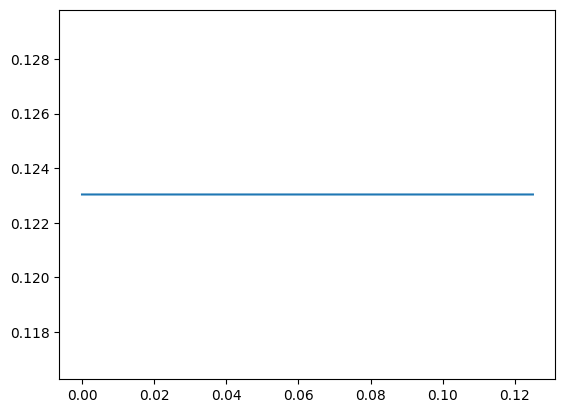

In [9]:
# dynamics equations
from matplotlib import pyplot as plt

# forward euler to plot some stuff
def euler(x0, dt, steps, dynamics_params):
    t = np.zeros(steps+1)
    x = np.zeros((len(x0),steps+1))
    x[:,0] = x0
    for i in range(1,steps+1):
        f = hsa_hopper.dynamics.evaluate(x[0,i-1],x[1,i-1],0,dynamics_params)
        x[0,i] = x[0,i-1] + dt*x[1,i-1] + (.5*dt**2)*f
        x[1,i] = x[1,i-1] + dt*f
        t[i] = t[i-1] + dt
    return x,t

x0 = np.array([theta1,thetadot1])
x,t = euler(x0,1e-4,int(1e4*tf),dynamics_params)
plt.plot(t,np.array([y(_x) for _x in x[0,:]]))

In [10]:
import math
import hsa_hopper.collocation
collo_params = hsa_hopper.collocation.CollocationParameters(1,4,3,0,tf)
u = np.zeros(x.shape[1])
x_interp, u_interp = hsa_hopper.collocation.fit_interpolation(x[0,:],u,t,collo_params)

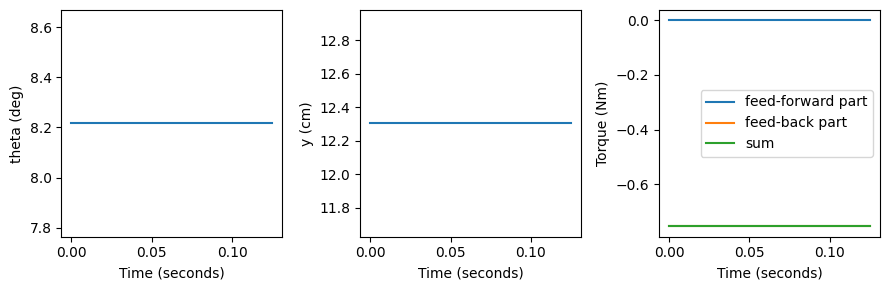

In [11]:
# visualise this interpolation
def make_interp_figure(x_interp, u_interp, dynamics_params):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(9,3))

    tk = x_interp.tk
    t_mat= np.vstack([np.linspace(tk[i], tk[i+1],100) for i in range(x_interp.M)])

    # compute interpolations
    x_data = np.hstack([[ x_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(x_interp.M)])
    y_data= y(x_data)
    u_data= np.hstack([[ u_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(u_interp.M)])
    t = t_mat.flatten()

    # make figures
    ax[0].plot(t, 180/np.pi*x_data)
    ax[1].plot(t, 100*y_data)
    ax[2].plot(t, u_data, label='feed-forward part')
    ax[2].plot(t, dynamics_params.Kx*(dynamics_params.x0-x_data), label='feed-back part')
    ax[2].plot(t, u_data+dynamics_params.Kx*(dynamics_params.x0-x_data), label='sum')

    ax[0].set_xlabel('Time (seconds)')
    ax[1].set_xlabel('Time (seconds)')
    ax[2].set_xlabel('Time (seconds)')

    ax[0].set_ylabel('theta (deg)')
    ax[1].set_ylabel('y (cm)')
    ax[2].set_ylabel('Torque (Nm)')
    ax[2].legend()
    fig.tight_layout()
    
make_interp_figure(x_interp,u_interp,dynamics_params)

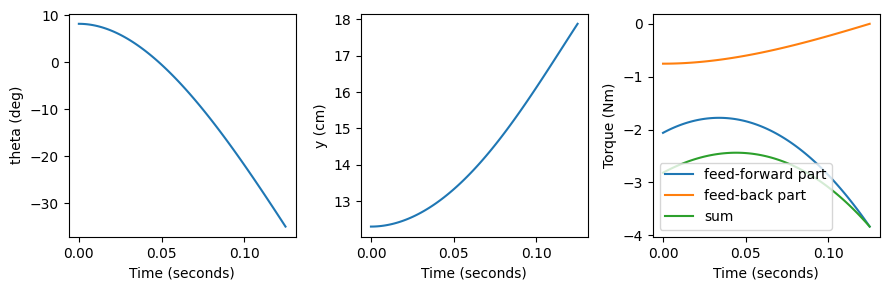

In [12]:
# finally apply dynamics constraints
# z = result.x
import yaml
from scipy.optimize import minimize
z = np.hstack([x_interp.mat.flatten(),u_interp.mat.flatten()])
bvp = hsa_hopper.collocation.HopBVP(
    [theta1,thetadot1],
    [thetaN,thetadotN],
    [-45*np.pi/180,-10],
    [45*np.pi/180,-2],
    dynamics_params,
    collo_params
)
result = bvp.optimize(z, options = {
    'ftol': 1e-2,
    'maxiter': 20,
    'eps': 1e-6
})

x_interp = hsa_hopper.collocation.PiecewiseInterpolation(bvp.c_mat,collo_params.tk)
u_interp = hsa_hopper.collocation.PiecewiseInterpolation(bvp.d_mat,collo_params.tk)
make_interp_figure(x_interp, u_interp,dynamics_params)

stance_controller = {
    'Kx': dynamics_params.Kx,
    'x0': dynamics_params.x0,
    'u_interp': u_interp.attribute_dict()
}

with open('no_hsa_hop_start.yaml','w') as f:
    yaml.dump(stance_controller, f, yaml.Dumper)

In [13]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7.867620158439135
       x: [-8.583e-02 -4.178e-01 -1.479e-01  4.066e-02 -1.981e+00
           -8.866e-01 -9.678e-01]
     nit: 4
     jac: [ 5.559e+00  3.288e-01  1.999e+00  1.991e-01 -5.559e+00
           -3.288e-01 -1.999e+00]
    nfev: 5
    njev: 4

In [14]:
# the system is evidently stable with respect to perturbations in velocity initial conditions
# for x in hops:
#     plt.plot(100*y(x[0,:]))